In [1]:
from idaes.apps.grid_integration import PriceTakerModel
import pandas as pd
import pyomo.environ as pyo
import flowsheet as fs
import utils
from params import FlexDesalParams

In [2]:
price_data = pd.read_csv("sbce_pricesignal.csv")
price_data["Energy Rate"] = (
    price_data["electric_energy_0_2022-07-05_2022-07-14_0"]
    + price_data["electric_energy_1_2022-07-05_2022-07-14_0"]
    + price_data["electric_energy_2_2022-07-05_2022-07-14_0"]
    + price_data["electric_energy_3_2022-07-05_2022-07-14_0"]
)
price_data["Fixed Demand Rate"] = price_data["electric_demand_maximum_2022-07-05_2022-07-14_0"]
price_data["Var Demand Rate"] = price_data["electric_demand_peak-summer_2022-07-05_2022-07-14_0"]
price_data["Emissions Intensity"] = 0
price_data["Customer Cost"] = price_data["electric_customer_0_2022-07-05_2022-07-14_0"]

In [3]:
# Create an instance of the PriceTakerModel
m = PriceTakerModel()

# Instantiate an object containing the model parameters
m.params = FlexDesalParams(
    start_date="2022-07-05 00:00:00",
    end_date="2022-07-15 00:00:00",
    annual_production_AF=3125,
)
m.params.intake.nominal_flowrate = 1063.5
m.params.ro.update({
    "startup_delay": 8,
    "minimum_downtime": 4,
    "nominal_flowrate": 337.670,
    "surrogate_type": "quadratic_surrogate",
    "surrogate_a": 11.509,
    "surrogate_b": -10.269,
    "surrogate_c": 5.627,
    "surrogate_d": 0,
    "minimum_recovery": 0.4,
    "nominal_recovery": 0.465,
    "maximum_recovery": 0.52,
    "allow_variable_recovery": True,
})

In [4]:
# Append LMP data to the model
m.append_lmp_data(lmp_data=price_data["Energy Rate"])

# Build the multiperiod model
m.build_multiperiod_model(
    flowsheet_func=fs.build_desal_flowsheet,
    flowsheet_options={"params": m.params},
)

# Update the time-varying parameters other than the LMP, such as
# demand costs and emissions intensity. LMP value is updated by default
m.update_operation_params({
    "fixed_demand_rate": price_data["Fixed Demand Rate"],
    "variable_demand_rate": price_data["Var Demand Rate"],
    "emissions_intensity": price_data["Emissions Intensity"],
    "customer_cost": price_data["Customer Cost"],
})

# Add demand cost and fixed cost calculation constraints
fs.add_demand_and_fixed_costs(m)

# Add the startup delay constraints
fs.add_delayed_startup_constraints(m)

# Construct useful expressions or model-level constraints
m.total_water_production = pyo.Expression(
    expr=m.params.timestep_hours * sum(m.period[:, :].posttreatment.product_flowrate)
)
m.total_energy_cost = pyo.Expression(expr=sum(m.period[:, :].energy_cost))
m.total_demand_cost = pyo.Expression(expr=m.fixed_demand_cost + m.variable_demand_cost)
m.total_customer_cost = pyo.Expression(
    expr=sum(m.period[:, :].customer_cost) * m.params.num_months
)
m.total_electricity_cost = pyo.Expression(
    expr=m.total_energy_cost + m.total_demand_cost + m.total_customer_cost
)

In [5]:
# Off-design operation is not allowed. Therefore the minimum stable operation
# range is the same as the capacity (i.e., op_range_lb = 1)
for skid in range(1, m.params.ro.num_ro_skids + 1):
    m.add_capacity_limits(
        op_block_name=f"reverse_osmosis.ro_skid[{skid}]",
        commodity="feed_flowrate",
        capacity=m.params.ro.nominal_flowrate,
        op_range_lb=1,
    )

2025-06-20 13:07:35 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created capacity limit constraints for commodity feed_flowrate in operation block reverse_osmosis.ro_skid[1] at ro_skid_1_feed_flowrate_limits
2025-06-20 13:07:36 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created capacity limit constraints for commodity feed_flowrate in operation block reverse_osmosis.ro_skid[2] at ro_skid_2_feed_flowrate_limits
2025-06-20 13:07:36 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created capacity limit constraints for commodity feed_flowrate in operation block reverse_osmosis.ro_skid[3] at ro_skid_3_feed_flowrate_limits


NOTE: If the minimum uptime = 1 and the minimum downtime = 1, then the minimum uptime and downtime constraints are not needed.
However, the startup variable is needed for delayed startup. So, we will add the minimum uptime and downtime constraints only
for one skid. These constraints are not needed for the remaining skids.

In [6]:
# Add startup and shutdown constraints for ro_skids
for skid in range(1, m.params.ro.num_ro_skids + 1):
    m.add_startup_shutdown(
        op_block_name=f"reverse_osmosis.ro_skid[{skid}]",
        up_time=m.params.ro.minimum_uptime,
        down_time=m.params.ro.minimum_downtime,
    )

2025-06-20 13:07:38 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created startup/shutdown constraints for operation model  reverse_osmosis.ro_skid[1] at ro_skid_1_startup_shutdown.
2025-06-20 13:07:38 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created startup/shutdown constraints for operation model  reverse_osmosis.ro_skid[2] at ro_skid_2_startup_shutdown.
2025-06-20 13:07:38 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created startup/shutdown constraints for operation model  reverse_osmosis.ro_skid[3] at ro_skid_3_startup_shutdown.


In [7]:
# Feed flowrate to the intake is fixed, and it does not vary with time
m.fix_operation_var("intake.feed_flowrate", m.params.intake.nominal_flowrate)
m.fix_operation_var("pretreatment.op_mode", 1)

In [8]:
fs.constrain_water_production(m)

In [9]:
if not m.params.ro.allow_variable_recovery:
    # Need to fix the variable recovery
    utils.fix_recovery(m, recovery=m.params.ro.nominal_recovery)

In [10]:
m.obj = pyo.Objective(
    expr=m.total_energy_cost + m.total_demand_cost,
    sense=pyo.minimize,
)

In [11]:
# # Use the following code to optimize net profit
# m.add_hourly_cashflows(
#     revenue_streams=["water_revenue", "demand_response_revenue"],
#     operational_costs=["emissions_cost", "energy_cost"],
# )
# m.add_overall_cashflows(
#     other_costs=[m.fixed_demand_cost, m.variable_demand_cost, m.fixed_monthly_cost]
# )

# m.add_objective_function(objective_type="net_profit")

In [12]:
solver_name = "gurobi"
mip_gap = 0.03

if solver_name == "gurobi":
    # solver = utils.get_gurobi_solver_model(m, mip_gap=0.005)
    solver = pyo.SolverFactory("gurobi")
    solver.options["MIPGap"] = mip_gap
    solver.solve(m, tee=True)

elif solver_name == "scip":
    solver = pyo.SolverFactory("scip")
    solver.solve(m, tee=True)

elif solver_name in ["baron", "cplex"]:
    solver = pyo.SolverFactory("gams")
    solver.solve(
        m, tee=True, solver=solver_name, add_options=[f"options optcr={mip_gap};"]
    )

Read LP format model from file C:\Users\RADHAK~1\AppData\Local\Temp\tmpwvf2uf0_.pyomo.lp
Reading time = 0.07 seconds
x1: 49910 rows, 48003 columns, 149808 nonzeros
Set parameter MIPGap to value 0.03
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (26100.2))

CPU model: 13th Gen Intel(R) Core(TM) i9-13950HX, instruction set [SSE2|AVX|AVX2]
Thread count: 24 physical cores, 32 logical processors, using up to 32 threads

Non-default parameters:
MIPGap  0.03

Optimize a model with 49910 rows, 48003 columns and 149808 nonzeros
Model fingerprint: 0x2c0caf44
Model has 8640 quadratic constraints
Variable types: 37443 continuous, 10560 integer (10560 binary)
Coefficient statistics:
  Matrix range     [1e-02, 1e+03]
  QMatrix range    [1e+00, 1e+01]
  QLMatrix range   [1e+00, 1e+01]
  Objective range  [3e-02, 1e+00]
  Bounds range     [4e-01, 3e+00]
  RHS range        [1e+00, 2e+05]
  QRHS range       [6e+00, 6e+00]
Presolve removed 31361 rows and 21925 columns
Presolve tim

In [13]:
# Write optimal values of all operational variables to a csv file
m.get_operation_var_values().to_csv("dummy_result.csv")

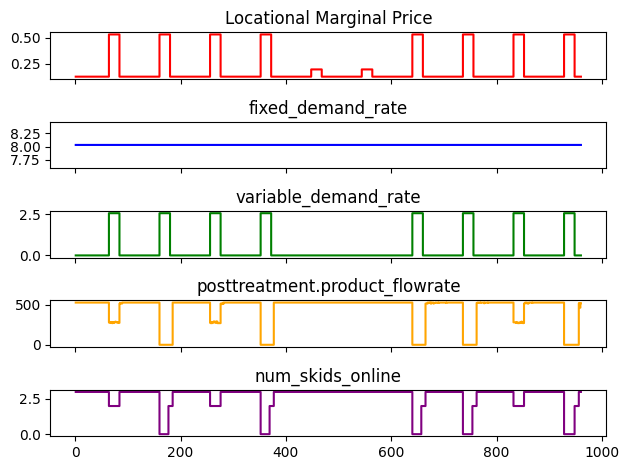

In [14]:
fig, axs = m.plot_operation_profile(
    [
        "fixed_demand_rate",
        "variable_demand_rate",
        "posttreatment.product_flowrate",
        "num_skids_online",
    ],
)

In [15]:
m.get_design_var_values()

{'fixed_demand_cost': 5657.947123229169,
 'variable_demand_cost': 1076.0834800607392,
 'fixed_monthly_cost': 247096.7741935484,
 'total_water_production': 105606.16438355984,
 'total_energy_cost': 70919.7563826574,
 'total_demand_cost': 6734.030603289908,
 'total_customer_cost': 1177.3419354838923,
 'total_electricity_cost': 78831.1289214312}